In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import tqdm
from params import *

%matplotlib inline

## PATH

In [3]:
data_file = f'../dataarray/da_staged_{patient}.nc'

## PARAMS

In [4]:
eeg_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1']
respi_chan = 'DEBIT'
ecg_chan = 'ECG'
eog_chans = ['EOGDt-A2','EOGG-A1']
sel_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1','DEBIT','ECG']
stages = ['W','R','N1','N2','N3']

In [5]:
srate = 256

In [6]:
method = 'cmo'
# method = 'moi'

In [7]:
if method == 'moi':
    step = 40 # n_wavelets
    start_freq = 10 # start wavelet freq
    stop_freq = 20 # stop wavelet freq
    amp = 1
    time_cmw = np.arange(-2,2,1/srate)
    range_freqs = np.linspace(start_freq,stop_freq,step)
    n_cycles = np.linspace(5,10,step) # 5 to 10 cycles from 10 to 20 Hz freqs , equally spaced
    m = 0

    cmw_family_params = {'amp':amp, 'time':time_cmw, 'n_cycles':n_cycles, 'm':m, 'range':range_freqs}
elif method == 'cmo':
    f0 = 10
    f_start = 10
    f_stop = 20
    delta_freq = 0.2

In [8]:
save = True

TOOLS

GO

In [9]:
if save:
    da = xr.load_dataarray(data_file)
    da = da.sel(stage = stage_to_study).dropna(dim='time')
    chans = list(da.coords['chan'].values)
    
    concat = []
    
    loop = range(len(eeg_chans))
    loop = tqdm.tqdm(loop, desc='chan')
    
    for i in loop:
        chan = eeg_chans[i]
        sig = da.loc[chan, :].dropna(dim='time').values
        
        if method == 'moi':
            time_sig = gh.time_vector(sig=sig, srate=srate)
            da_features = gh.extract_features_from_cmw_family(sig, time_sig, cmw_family_params, module_method='abs')
            concat.append(da_features)
        elif method == 'cmo':
            tf_matrix = gh.cmo_tf(sig=sig, f_start=f_start , f_stop=f_stop, delta_freq=delta_freq, srate=srate, f0 = f0) 
            concat.append(tf_matrix)
    da_tf = xr.concat(concat, dim = 'chan')
    da_tf = da_tf.assign_coords({'chan':eeg_chans})
    
    da_tf.to_netcdf(f'../dataarray/da_tf_{patient}.nc')
else:
    da_tf = xr.load_dataarray(f'../dataarray/da_tf_{patient}.nc')

In [10]:
da_tf

<xarray.DataArray (chan: 8, freqs: 100, time: 1743360)>
array([[[0.5170305 , 0.51200003, 0.50697609, ..., 0.53215514,
         0.52710864, 0.5220669 ],
        [0.75190079, 0.74918221, 0.74647858, ..., 0.76014169,
         0.75738097, 0.75463386],
        [1.30261546, 1.30181465, 1.30101055, ..., 1.30499717,
         1.30420682, 1.30341288],
        ...,
        [0.27709325, 0.2761862 , 0.27528175, ..., 0.27982001,
         0.27891115, 0.2780019 ],
        [0.17744591, 0.17527827, 0.17310351, ..., 0.18388808,
         0.18175255, 0.17960459],
        [0.15843511, 0.15540138, 0.15234118, ..., 0.16736756,
         0.16441915, 0.16144135]],

       [[1.33964549, 1.34275649, 1.34585983, ..., 1.33026637,
         1.33340044, 1.33652681],
        [0.85587838, 0.85711257, 0.85835613, ..., 0.85223096,
         0.85343767, 0.85465344],
        [0.25494501, 0.25347434, 0.25205234, ..., 0.25963519,
         0.25802681, 0.25646296],
...
        [2.97746988, 2.97403214, 2.97051601, ..., 2.98731453,
         2.98411088, 2.9808294 ],
        [2.85437301, 2.85269315, 2.85093852, ..., 2.85896714,
         2.85750967, 2.85597841],
        [2.59166438, 2.59227186, 2.59279825, ..., 2.58935993,
         2.59020794, 2.59097625]],

       [[1.90482994, 1.90673511, 1.90860021, ..., 1.89887461,
         1.90089962, 1.90288476],
        [1.64012886, 1.64052833, 1.64088946, ..., 1.63870067,
         1.63921501, 1.63969108],
        [1.67623115, 1.67495154, 1.67364441, ..., 1.67990428,
         1.67870758, 1.67748319],
        ...,
        [1.87699256, 1.88298898, 1.88883473, ..., 1.85810936,
         1.86455171, 1.87084646],
        [1.9363847 , 1.941126  , 1.94573641, ..., 1.92138559,
         1.92651347, 1.93151352],
        [2.03998515, 2.04334238, 2.04658516, ..., 2.02923439,
         2.03293036, 2.03651422]]])
Coordinates:
  * freqs    (freqs) float64 10.0 10.1 10.2 10.3 10.4 ... 19.6 19.7 19.8 19.9
  * time     (time) float64 0.0 0.003906 0.007812 ... 6.81e+03 6.81e+03 6.81e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

In [11]:
gh.get_memory(da_tf)

11.157504000000001 Go


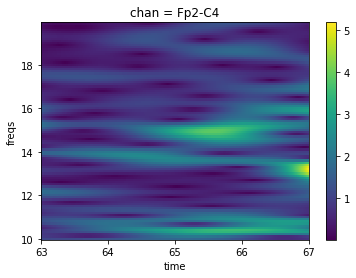

In [12]:
da_tf.loc['Fp2-C4',:,63:67].plot()

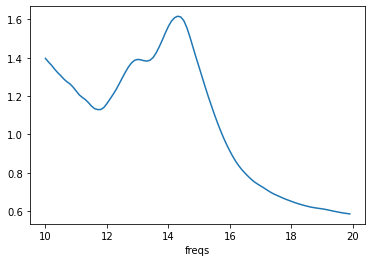

In [13]:
da_tf.loc[:,:,:].mean(['time','chan']).plot()

In [14]:
if save:
    resp_features = pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx')
    loop = range(len(eeg_chans))
    loop = tqdm.tqdm(loop, desc='chan')
    concat = []
    for i in loop:
        chan = eeg_chans[i]
        da_stretch_cycle = gh.tf_cycle_stretch(da=da_tf, chan=chan, rsp_features=resp_features, nb_point_by_cycle=1000, inspi_ratio = 0.4)
        concat.append(da_stretch_cycle)
        
    da_tf_stretched = xr.concat(concat, dim = 'chan')
    da_tf_stretched = da_tf_stretched.assign_coords({'chan':eeg_chans})
    da_tf_stretched.to_netcdf(f'../dataarray/da_tf_stretched_{patient}.nc')
else:
    da_tf_stretched = xr.load_dataarray(f'../dataarray/da_tf_stretched_{patient}.nc')
del da_tf

In [15]:
gh.get_memory(da_tf_stretched)

15.0272 Go


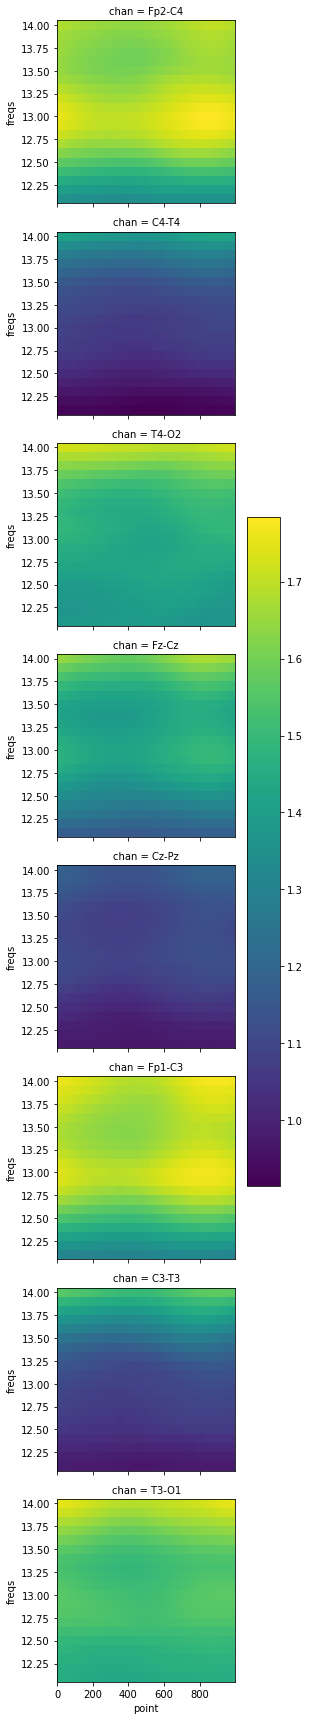

In [16]:
da_tf_stretched.loc[:,:,12:14,:].mean('cycle').plot.pcolormesh(x='point', row = 'chan')

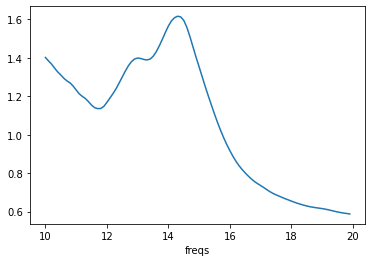

In [17]:
da_tf_stretched.loc[:,:,:,:].mean(['cycle','chan','point']).plot()

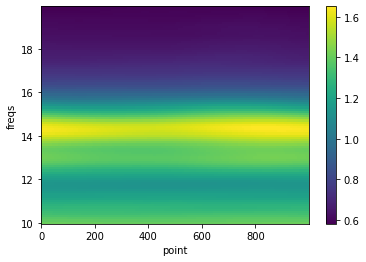

In [18]:
da_tf_stretched.loc[:,:,:,:].mean(['cycle','chan']).plot()

In [19]:
da_tf_stretched.coords

Coordinates:
  * cycle    (cycle) int64 0 1 2 3 4 5 6 ... 2341 2342 2343 2344 2345 2346 2347
  * freqs    (freqs) float64 10.0 10.1 10.2 10.3 10.4 ... 19.6 19.7 19.8 19.9
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

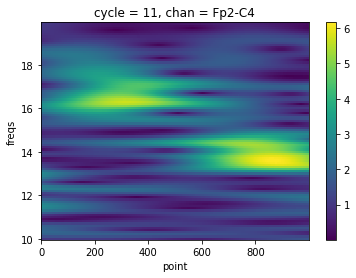

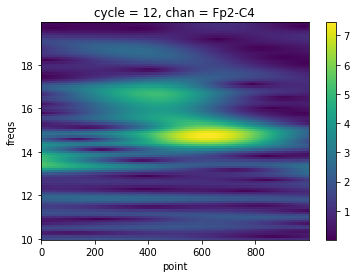

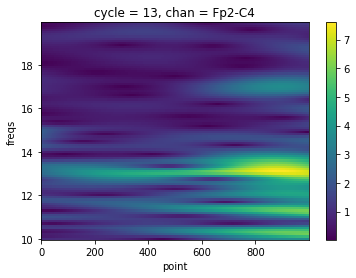

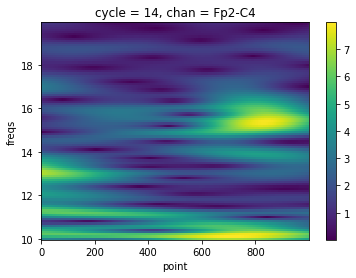

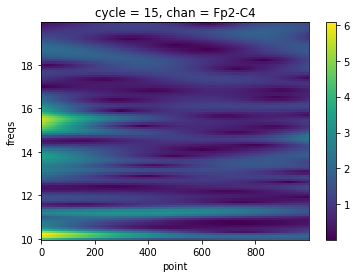

In [20]:
for i in range(10,15):
    da_tf_stretched.loc['Fp2-C4',i+1,:,:].plot.pcolormesh(x='point')
    plt.show()

In [21]:
freqs = da_tf_stretched.coords['freqs'].values

In [22]:
cycles_spindled = np.load(f'../df_analyse/cycles_spindled_{patient}.npy')

In [23]:
da_tf_stretched

<xarray.DataArray (chan: 8, cycle: 2348, freqs: 100, point: 1000)>
array([[[[0.27814551, 0.28019022, 0.28226229, ..., 0.68936314,
          0.68716033, 0.68496613],
         [0.6179095 , 0.61828803, 0.61867841, ..., 0.7663811 ,
          0.76487688, 0.76337063],
         [1.21268814, 1.21210368, 1.21151922, ..., 0.69310114,
          0.69095805, 0.68880621],
         ...,
         [0.28273586, 0.28306351, 0.28338299, ..., 0.74325962,
          0.74603189, 0.74880255],
         [0.22010803, 0.22129707, 0.22247231, ..., 0.57752684,
          0.5822041 , 0.58687891],
         [0.22318857, 0.22495934, 0.22671533, ..., 0.46484081,
          0.47157145, 0.47827353]],

        [[0.68278072, 0.68137547, 0.67997301, ..., 0.03117233,
          0.02978514, 0.02840861],
         [0.76186246, 0.76088751, 0.75991203, ..., 0.16303282,
          0.16361042, 0.16419371],
         [0.68664571, 0.68524522, 0.68384216, ..., 0.24059715,
          0.24216457, 0.24373499],
...
         [0.87606341, 0.87793763, 0.87980024, ..., 1.3913415 ,
          1.39226454, 1.39316878],
         [0.76225668, 0.76381583, 0.7653656 , ..., 1.58809813,
          1.59007842, 1.5920378 ],
         [0.66209003, 0.6633863 , 0.66467802, ..., 1.73130543,
          1.73423933, 1.73715099]],

        [[1.47807846, 1.47903096, 1.47997797, ..., 0.5561482 ,
          0.55682752, 0.55750615],
         [1.1145472 , 1.11606369, 1.11757163, ..., 1.30216234,
          1.30359201, 1.30502396],
         [1.2124494 , 1.21282222, 1.21318498, ..., 1.96517901,
          1.96754089, 1.96990031],
         ...,
         [1.39405425, 1.39481574, 1.39556527, ..., 0.48616803,
          0.48872209, 0.49140664],
         [1.59397624, 1.59567258, 1.59735544, ..., 0.14640647,
          0.15297133, 0.15972787],
         [1.74004039, 1.74258194, 1.74510911, ..., 0.63345255,
          0.63524378, 0.63711835]]]])
Coordinates:
  * cycle    (cycle) int64 0 1 2 3 4 5 6 ... 2341 2342 2343 2344 2345 2346 2347
  * freqs    (freqs) float64 10.0 10.1 10.2 10.3 10.4 ... 19.6 19.7 19.8 19.9
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

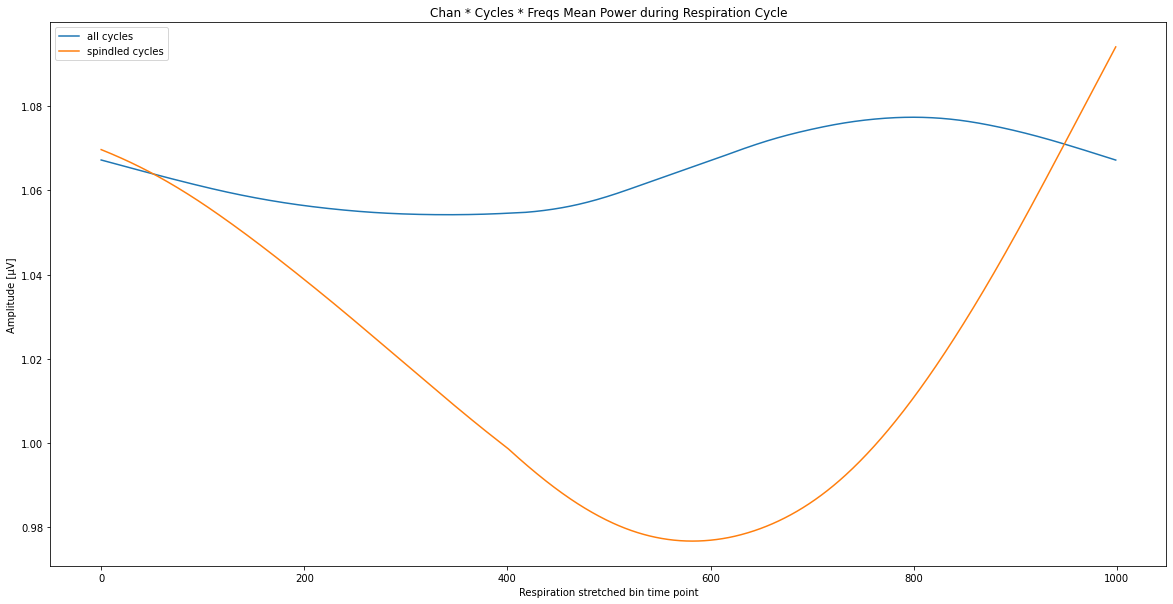

In [24]:
fig, ax = plt.subplots(figsize = (20,10)) # to save
da_tf_stretched.mean(['chan','cycle','freqs']).plot(ax=ax)
da_tf_stretched.sel(cycle = cycles_spindled - 1).mean(['chan','freqs','cycle']).plot(ax=ax)
ax.legend(['all cycles' , 'spindled cycles'])
ax.set_ylabel('Amplitude [µV]')
ax.set_xlabel('Respiration stretched bin time point')
ax.set_title('Chan * Cycles * Freqs Mean Power during Respiration Cycle')
if save:
    plt.savefig(f'../presentation/mean_chan_cycle_freq_power_lineplot_{patient}')
plt.show()

In [25]:
eeg_chans

['Fp2-C4', 'C4-T4', 'T4-O2', 'Fz-Cz', 'Cz-Pz', 'Fp1-C3', 'C3-T3', 'T3-O1']

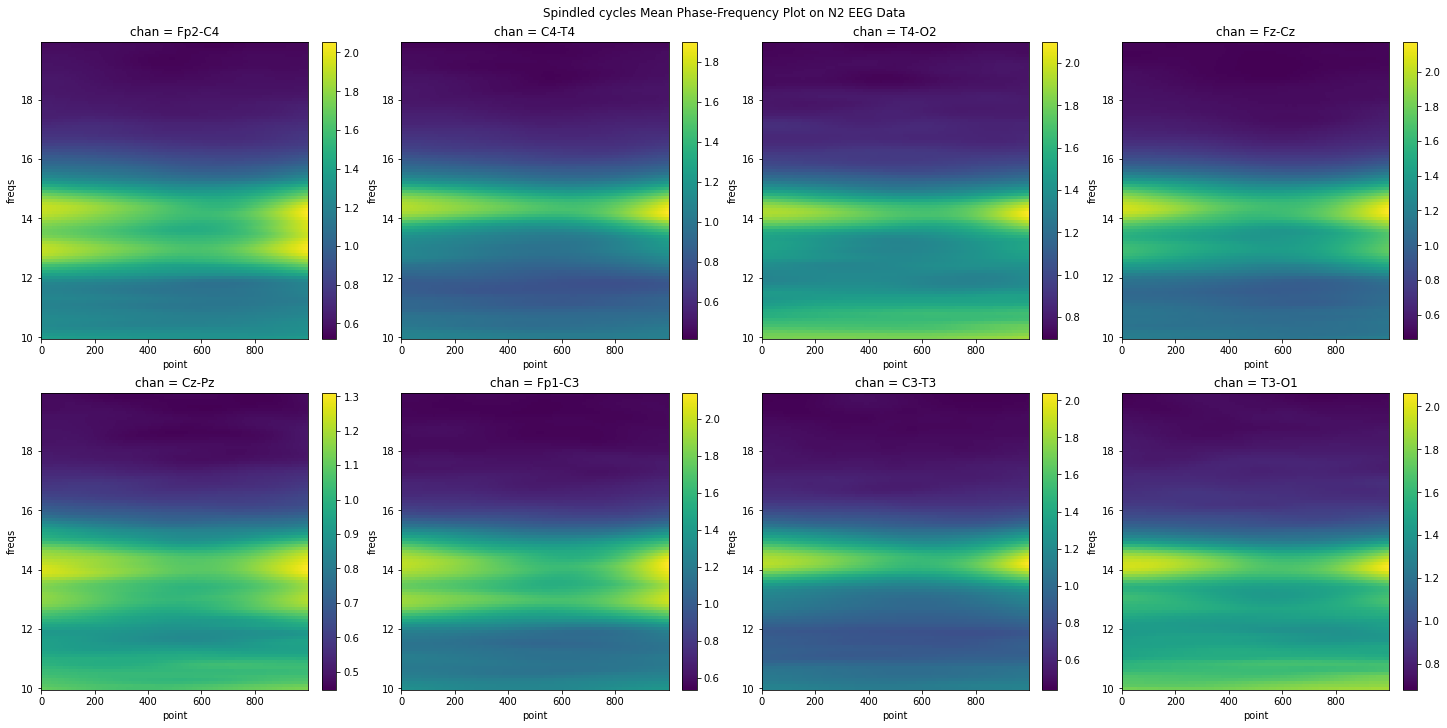

In [26]:
# to save
chans_1 = eeg_chans[:4]
chans_2 = eeg_chans[4:]
chans_merge = [ chans_1 , chans_2 ]
fig, axs = plt.subplots(nrows = 2, ncols = len(chans_1), figsize = (20,10), constrained_layout = True) # to save
fig.suptitle('Spindled cycles Mean Phase-Frequency Plot on N2 EEG Data')
for row , chan_i in enumerate(chans_merge):
    for col, chan in enumerate(chan_i):
        ax = axs[row, col]
        da_tf_stretched.loc[chan,cycles_spindled - 1, :,:].mean('cycle').plot.pcolormesh(x='point', y='freqs', ax=ax)
if save:
    plt.savefig(f'../presentation/phase_freq_2D_plot_{patient}')
plt.show()

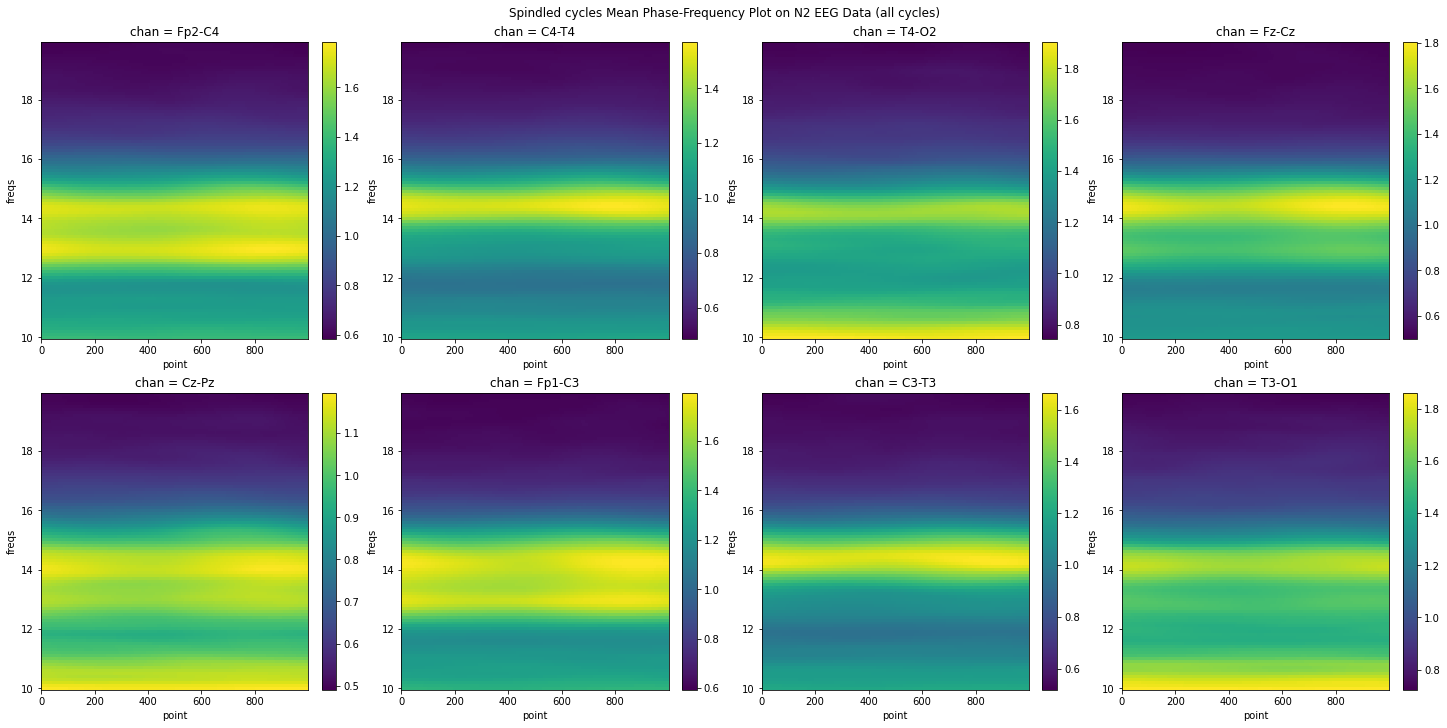

In [27]:
# to save
chans_1 = eeg_chans[:4]
chans_2 = eeg_chans[4:]
chans_merge = [ chans_1 , chans_2 ]
fig, axs = plt.subplots(nrows = 2, ncols = len(chans_1), figsize = (20,10), constrained_layout = True) # to save
fig.suptitle('Spindled cycles Mean Phase-Frequency Plot on N2 EEG Data (all cycles)')
for row , chan_i in enumerate(chans_merge):
    for col, chan in enumerate(chan_i):
        ax = axs[row, col]
        da_tf_stretched.loc[chan,:, :,:].mean('cycle').plot.pcolormesh(x='point', y='freqs', ax=ax)
if save:
    plt.savefig(f'../presentation/phase_freq_2D_plot_all_cycles_{patient}')
plt.show()